In [1]:
# ============================================
# 0) 환경 준비
# ============================================
#!pip -q install datasets==2.19.0 pandas regex transformers==4.44.2 accelerate
import math
import random, re
import numpy as np
import pandas as pd
from collections import Counter
from datasets import load_dataset, Dataset, DatasetDict
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [2]:
# ============================================
# 1) 데이터 로드 (facebook/empathetic_dialogues)
#    - 주요 필드:
#      conv_id, utterance_idx, context(=emotion label), prompt(=situation), speaker_idx, utterance, ...
# ============================================
ds = load_dataset("facebook/empathetic_dialogues")
# 필요 시 전체 split 병합 가능하지만, 여기서는 train만 테스트 후
# 아래에서 전체 합치기로 진행.
all_dfs = []
for split in ds.keys():
    all_dfs.append(ds[split].to_pandas())
raw_df = pd.concat(all_dfs, ignore_index=True)
print("Raw rows:", len(raw_df))
raw_df.head(3)

c:\Users\yunhs\anaconda3\envs\nlp_env\lib\site-packages\datasets\load.py:1486: FutureWarning: The repository for facebook/empathetic_dialogues contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/facebook/empathetic_dialogues
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Raw rows: 99646


,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags
0,hit:0_conv:1,1,sentimental,I remember going to the fireworks with my best...,1,I remember going to see the fireworks with my ...,5|5|5_2|2|5,
1,hit:0_conv:1,2,sentimental,I remember going to the fireworks with my best...,0,Was this a friend you were in love with_comma_...,5|5|5_2|2|5,
2,hit:0_conv:1,3,sentimental,I remember going to the fireworks with my best...,1,This was a best friend. I miss her.,5|5|5_2|2|5,


In [3]:
# ============================================
# 2) 전처리: 특수 토큰(placeholder) 복원
#    - people_comma_ 처럼 쉼표/마침표 등을 안전치환한 흔적 복구
# ============================================
def restore_punctuation(text: str) -> str:
    if not isinstance(text, str):
        return text
    return (text
            .replace("_comma_", ",")
            .replace("_period_", ".")
            .replace("_questionmark_", "?")
            .replace("_exclamationpoint_", "!")
            .replace("_apostrophe_s_", "'s")
            .replace("_quote_", '"')
            .replace("_slash_", "/")
            .replace("_dash_", "-")
            )

for col in ["prompt", "utterance"]:
    raw_df[col] = raw_df[col].apply(restore_punctuation)


In [4]:
# ============================================
# 3) (context, response) 페어 구성
#    - 같은 conv_id 묶고 utterance_idx로 정렬
#    - listener(speaker_idx==1) 턴을 response로 사용
#    - context = situation(prompt) + 직전 utterance (간단 결합)
#    - emotion = 첫 턴의 context(=감정 라벨)
# ============================================
pairs = []
for conv_id, g in raw_df.groupby("conv_id"):
    g = g.sort_values("utterance_idx").reset_index(drop=True)
    if len(g) < 2:
        continue
    # 대화의 공통 메타
    situation = restore_punctuation(str(g.iloc[0].get("prompt", ""))).strip()
    emotion_label = str(g.iloc[0].get("context", "")).strip()  # 'sentimental' 등 32개 카테고리
    for i in range(1, len(g)):
        cur = g.iloc[i]
        prev = g.iloc[i-1]
        if int(cur.get("speaker_idx", -1)) == 1:
            prev_u = restore_punctuation(str(prev.get("utterance", ""))).strip()
            cur_u  = restore_punctuation(str(cur.get("utterance", ""))).strip()
            if prev_u and cur_u:
                context_text = (situation + " [SEP] " + prev_u).strip() if situation else prev_u
                pairs.append({
                    "conv_id": conv_id,
                    "context": context_text,
                    "response": cur_u,
                    "emotion": emotion_label
                })

pairs_df = pd.DataFrame(pairs)
print("Pairs:", len(pairs_df))
pairs_df.head(5)

Pairs: 2124


,conv_id,context,response,emotion
0,hit:0_conv:0,I felt guilty when I was driving home one nigh...,Did you suffer any injuries?,guilty
1,hit:0_conv:0,I felt guilty when I was driving home one nigh...,Why did you feel guilty? People really shouldn...,guilty
2,hit:0_conv:1,I remember going to the fireworks with my best...,This was a best friend. I miss her.,sentimental
3,hit:0_conv:1,I remember going to the fireworks with my best...,We no longer talk.,sentimental
4,hit:107_conv:214,Got asked to my boss' office. Thought I was ge...,I definitely did!,surprised


In [5]:
print(pairs_df.loc[0:1,['context','response']])

                                             context  \
0  I felt guilty when I was driving home one nigh...   
1  I felt guilty when I was driving home one nigh...   

                                            response  
0                       Did you suffer any injuries?  
1  Why did you feel guilty? People really shouldn...  


# 1. 데이터 증강하기(공감 1점, 공감 3점, 공감 5점(원래 데이터))

In [6]:
# ============================================
# 4) 데이터 증강 (Positive / Medium / Negative)
#    - Positive: 원본 그대로 (seed=5.0)
#    - Medium: 공감표현 약화/제거 (seed=3.0)
#    - Negative: 다른 conv_id의 응답을 랜덤 스왑하여 문맥 불일치 (seed=1.5)
# ============================================
import re
import random

## medium으로 만들기 과정

# 1) 공감/지지 표현, 반영/확언, 완충어(hedges), 강조부사, 감정형용사 등 광범위 커버
PHRASE_REPLACEMENTS = [
    # --- 직접 공감/사과 ---
    (r"\bi\s*(am|’m|'m)?\s*(so\s+|really\s+|very\s+)?sorry\b", " "),               # I'm (so) sorry
    (r"\bmy\s+condolences\b", " "),
    (r"\bi\s*(am|’m|'m)?\s*(so\s+|really\s+|very\s+)?glad\b", " "),               # 감정 강조 제거

    # --- 이해/공감 ---
    (r"\bi\s*(am|’m|'m)?\s*(so\s+|really\s+|very\s+)?(understand|get|hear|feel)\b", " "),
    (r"\bi\s+can\s+(imagine|see|tell)\b", " "),
    (r"\bi\s+know\s+how\b", " "),
    (r"\bi\s+(empathize|sympathize)\b", " "),

    # --- 반영/확언(상대 감정 추정) ---
    (r"\bit\s+(seems|sounds)\s+like\b", " "),
    (r"\byou\s+must\s+feel\b", " "),
    (r"\bthat\s+must\s+be\b", " "),

    # --- 지지/가용성 ---
    (r"\bi\s*(am|’m|'m)?\s+here\s+(for\s+you)?\b", " "),
    (r"\b(let\s+me\s+know|we\s+can\s+talk|i\s+can\s+help)\b", " "),

    # --- 완충/여지 ---
    (r"\b(if\s+you\s+want|take\s+your\s+time|when\s+you(’|'|)\s*re\s+ready|no\s+pressure)\b", " "),

    # --- 감탄사/이모티콘/구두점 과다 ---
    (r"[!]+", "."),
    (r"[:;]-?[)D\(\]/\\Pp]+", " "),  # 간단한 이모티콘
    (r"[“”\"‹›«»]+", " "),
    (r"\s{2,}", " "),
]

# 2) 감정 형용사/부사 약화(과잉 정서의 톤 다운)
INTENSIFIERS = r"(so|really|very|super|totally|absolutely|extremely|incredibly)"
EMO_ADJ = r"(hard|tough|stressful|devastating|awful|sad|upsetting|terrible|rough|painful|frustrating|overwhelming)"
EMO_WEAKENERS = [
    (rf"\b{INTENSIFIERS}\s+{EMO_ADJ}\b", "somewhat"),
    (rf"\b{EMO_ADJ}\b", ""),  # 과감히 제거 (필요하면 "difficult" → "difficult" 유지로 바꿔도 됨)
]

# 3) 정리용
def clean_spaces(t):
    t = re.sub(r"\s{2,}", " ", t or "").strip()
    # 문장 끝 마침표 정리
    t = re.sub(r"(\s*\.){2,}$", ".", t)
    return t

# 4) 문장 단위 분해/치환 보조
SPLIT_SENT = re.compile(r"(?<=[\.\?\!])\s+")

def neutralize_sentence(sent: str) -> str:
    original = sent
    # 단계 A: 직접 치환
    for pat, repl in PHRASE_REPLACEMENTS:
        sent = re.sub(pat, repl, sent, flags=re.IGNORECASE)
    for pat, repl in EMO_WEAKENERS:
        sent = re.sub(pat, repl, sent, flags=re.IGNORECASE)
    sent = clean_spaces(sent)

    # 단계 B: 여전히 동일하면(치환 실패) → 강제 중립화 템플릿
    if clean_spaces(original.lower()) == clean_spaces(sent.lower()):
        # 중립 반응 템플릿 확장
        templates = [
            # --- 완전 중립 / 무표정형 ---
            "I see.",
            "Understood.",
            "Okay.",
            "Alright.",
            "Got it.",
            "Noted.",
            "That happened.",
            "That’s noted.",
            "I get it.",
            "Okay then.",

            # --- 약한 인정형(soft acknowledgment) ---
            "I understand.",
            "Makes sense.",
            "That’s how it goes.",
            "It happens.",
            "I see what you mean.",
            "Right.",
            "Sure.",
            "That’s fine.",

            # --- 약한 전환형(대화 이어가기용) ---
            "Anyway, I see.",
            "Well, okay.",
            "Hmm, alright.",
            "Gotcha.",
            "Yeah, okay.",
            "Oh, okay.",

            # --- 단문 리스폰스형 (neutral fillers) ---
            "Hmm.",
            "I guess so.",
            "Alright then.",
            "So it goes.",
            "That’s something.",
            "That’s a thing.",
            "If you say so.",
            "Fair enough.",
        ]
        return random.choice(templates)
    return sent


def make_medium_response_strong(text: str) -> str:
    # 문장 단위로 중립화 후 다시 합치기
    sents = SPLIT_SENT.split(text.strip())
    sents = [neutralize_sentence(s) for s in sents if s.strip()]
    out = clean_spaces(" ".join(sents))
    # 너무 짧아지면 맥락 보존용 가벼운 보정
    return out if out else "Okay."

responses_pool = pairs_df[["conv_id","response"]].copy()

## negative 만들기
def sample_negative_response(cur_conv_id):
    # 같은 conv_id가 아닌 응답 중 하나를 무작위 선택
    # (데이터 크기가 충분하다고 가정)
    while True:
        row = responses_pool.sample(n=1, random_state=random.randint(0, 10**9)).iloc[0]
        if row["conv_id"] != cur_conv_id:
            return row["response"]

pos_rows, med_rows, neg_rows = [], [], []
for i, row in pairs_df.iterrows():
    conv_id = row["conv_id"]
    ctx     = row["context"]
    rsp     = row["response"]
    emo     = row.get("emotion", "")

    # Positive
    pos_rows.append({
        "conv_id": conv_id, "context": ctx, "response": rsp,
        "type": "positive", "seed_score": 5.0, "emotion": emo
    })

    # Medium
    med_rsp = make_medium_response_strong(rsp)
    med_rows.append({
        "conv_id": conv_id, "context": ctx, "response": med_rsp,
        "type": "medium", "seed_score": 3.0, "emotion": emo
    })

    # Negative
    neg_rsp = sample_negative_response(conv_id)
    neg_rows.append({
        "conv_id": conv_id, "context": ctx, "response": neg_rsp,
        "type": "negative", "seed_score": 1.5, "emotion": emo
    })

aug_df = pd.DataFrame(pos_rows + med_rows + neg_rows)
print("Augmented samples:", len(aug_df))
aug_df.head(6)

Augmented samples: 6372


,conv_id,context,response,type,seed_score,emotion
0,hit:0_conv:0,I felt guilty when I was driving home one nigh...,Did you suffer any injuries?,positive,5.0,guilty
1,hit:0_conv:0,I felt guilty when I was driving home one nigh...,Why did you feel guilty? People really shouldn...,positive,5.0,guilty
2,hit:0_conv:1,I remember going to the fireworks with my best...,This was a best friend. I miss her.,positive,5.0,sentimental
3,hit:0_conv:1,I remember going to the fireworks with my best...,We no longer talk.,positive,5.0,sentimental
4,hit:107_conv:214,Got asked to my boss' office. Thought I was ge...,I definitely did!,positive,5.0,surprised
5,hit:107_conv:215,I am confident I will pass the test. [SEP] I h...,Good luck! Do your best. you sound well prepap...,positive,5.0,confident


In [7]:
## medium이 실제로 바뀌었는지 확인!! -> 모두 바뀐것을 확인

# aug_df에서 positive/medium만 추출해 base pair로 묶기
pos = aug_df[aug_df["type"]=="positive"][["conv_id","context","emotion","response"]].copy()
pos = pos.rename(columns={"response":"pos_response"})

med = aug_df[aug_df["type"]=="medium"][["conv_id","context","emotion","response"]].copy()
med = med.rename(columns={"response":"med_response"})

pair_pm = pd.merge(pos, med, on=["conv_id","context","emotion"], how="inner")

# 1-1) medium이 원문과 동일한 비율
same_mask = (pair_pm["pos_response"].str.strip() == pair_pm["med_response"].str.strip())
total = len(pair_pm)
same = int(same_mask.sum())
diff = total - same
print(f"[Medium 동일 여부] total={total} / 동일={same} ({same/total:.2%}) / 변경됨={diff} ({diff/total:.2%})")

# 1-2) 변경된 샘플 5개 프린트
pair_pm_changed = pair_pm[~same_mask].sample(min(5, diff), random_state=42)
pair_pm_changed[["pos_response","med_response"]]


[Medium 동일 여부] total=2126 / 동일=0 (0.00%) / 변경됨=2126 (100.00%)


,pos_response,med_response
282,Ah I see. It's always nice to have a goal to w...,Noted. That’s fine.
1999,That's great. Do you present often?,Okay. Okay.
1709,"Oh no, I hope she's just sick! Are you taking ...","Oh no, I hope she's just sick. Hmm."
988,"Yep. It is! I love hot pot, and it's actually ...","Well, okay. It is. Understood."
2018,Ohhhh sophomore year can be tough. How do you ...,Ohhhh sophomore year can be . I understand.


루브릭 설계 원칙
설계 원칙 (겹침 최소화)

- Affirmation(감정 인정): 사과/애도/유감 표현처럼 “상대의 감정/상황을 인정”하지만 상대의 상태를 재진술하지는 않음.
(예: I’m sorry, my condolences, that’s unfortunate)

- Reflection(재진술/반영): “상대의 상태를 요약/추정/반영”하는 문구. you feel / it seems / what I’m hearing is…
→ 여기로만 배정. (I understand 같은 자기상태 표명은 겹침을 피하려고 제외)

- Non-judgment(판단/충고 지연): 조언·명령(should/must/need to/why don’t you…)이 없음 + 완충/여지(hedges) 표현이 있음.
(if you’d like, maybe, might, could, take your time, no pressure, when you’re ready…)

- Supportiveness(지지/가용성): 도움/접근 가능성 제안. (I’m here for you, reach out, let me know, we can talk, call/text me, I can help…)

- Context specificity(구체성): 토큰 겹침 방식 유지(별도 함수).

점수 계산 로직(겹침 관리)

- Affirmation과 Reflection은 어휘군을 분리했으므로 그대로 독립 판정.

- Non-judgment는

  1. NONJUDGE_POS_PAT가 있고

  2. ADVICEY_PAT가 없을 때만 1점.

- Supportiveness는 독립 판정.

- Context specificity는 기존 - context_specificity() 유지.

# Rule-based 기반으로 공감 점수 라벨링하기

In [8]:
# ============================================
# 5) 루브릭 기반 자동 채점 (5요소: 0/1 합산)
#    - Affirmation, Reflection, Non-judgment, Context specificity, Supportiveness
# ============================================

# === 1) Affirmation: 사과/유감/애도/동감(단, 상대 상태 재진술 문구 제외) ===
AFFIRM_PAT = re.compile(
    r"""
    \b
    (
        i\s*(?:am|’m|'m)?\s*so?\s*sorry(?:\s+to\s+hear\s+that)?      # I'm (so) sorry (to hear that)
        | my\s+condolences
        | (?:that|it)\s+(?:is|’s|'s)?\s*(?:unfortunate|too\s+bad|a\s+shame)
        | I\s+feel\s+for\s+you
        | I\s+am\s+sorry\s+this\s+happened
        | sad\s+to\s+hear\s+that
        | sorry\s+to\s+hear
        | sorry\s+about\s+that
    )
    \b
    """,
    flags=re.IGNORECASE | re.VERBOSE
)

# === 2) Reflection: 상대 상태를 반영/추정 (you feel / it seems / what I'm hearing…) ===
REFLECT_PAT = re.compile(
    r"""
    \b
    (
        it\s+(?:seems|sounds)\s+like
        | you\s+(?:seem|appear)\b
        | you(?:’|'|)re\s+(?:feeling|going\s+through|dealing\s+with)
        | you\s+must\s+feel
        | I\s+can\s+(?:see|tell)\s+(?:that\s+)?you(?:’|'|)re
        | what\s+I(?:’|'|)\s*m\s+hearing\s+is
        | from\s+what\s+you\s+(?:said|are\s+sharing)
        | if\s+I\s+(?:understand|got)\s+(?:you\s+)?right
    )
    \b
    """,
    flags=re.IGNORECASE | re.VERBOSE
)

# === 3) Non-judgment: 완충/여지(hedges) + (권고/명령 표현이 없을 때 가산)
#  - 여기 패턴은 "있으면 +1"의 후보군이고, 실제 점수 부여는 아래 rubric_score에서
#    ADVICEY_PAT(금지어)가 없는 경우에만 가산되도록 합니다.
NONJUDGE_POS_PAT = re.compile(
    r"""
    \b
    (
        if\s+you(?:’|'|)d\s+like
        | if\s+you\s+want
        | maybe
        | might
        | could
        | perhaps
        | it(?:’|'|)s\s+okay\s+to
        | take\s+your\s+time
        | no\s+pressure
        | when\s+you(?:’|'|)re\s+ready
        | up\s+to\s+you
        | whenever\s+works
        | feel\s+free\s+to
    )
    \b
    """,
    flags=re.IGNORECASE | re.VERBOSE
)

# === 4) 조언/명령(감점/배제) 어휘: Non-judgment 점수의 조건부 배제에 사용 ===
ADVICEY_PAT = re.compile(
    r"""
    \b
    (
        you\s+should
        | you\s+must
        | you\s+need\s+to
        | you\s+have\s+to
        | you\s+ought\s+to
        | why\s+don(?:’|'|)t\s+you
        | just\s+\w+            # just do/try/say…
        | simply\s+\w+
        | stop\s+\w+
        | calm\s+down
        | cheer\s+up
        | don(?:’|'|)t\s+worry\s+about\s+it
    )
    \b
    """,
    flags=re.IGNORECASE | re.VERBOSE
)

# === 5) Supportiveness: 도움/접근 가능성/가용성 제안 ===
SUPPORT_PAT = re.compile(
    r"""
    \b
    (
        i(?:’|'|)m\s+here\s+(?:for\s+you|to\s+listen)?
        | I\s+can\s+help
        | let\s+me\s+know(?:\s+if\s+you\s+need\s+anything)?
        | reach\s+out
        | feel\s+free\s+to\s+(?:reach\s+out|message|text|call)
        | you\s+can\s+(?:message|text|call)\s+me
        | we\s+can\s+talk
        | I(?:’|'|)ll\s+be\s+here
        | I(?:’|'|)m\s+available
        | happy\s+to\s+listen
        | if\s+you\s+need\s+anything
        | I(?:’|'|)m\s+around
    )
    \b
    """,
    flags=re.IGNORECASE | re.VERBOSE
)


STOPWORDS = set("""
a an the and or but if while of in on at to for with without about above below over under again
more most some any each few who whom this that these those am is are was were be been being
do does did doing have has had having i you he she it we they me him her them my your our their
yours ours theirs as from by into through during before after up down out off then once here there
""".split())

def tokenize_simple(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    toks = [t for t in text.split() if t and t not in STOPWORDS]
    return toks

def context_specificity(context, response):
    c_toks = set(tokenize_simple(context))
    r_toks = set(tokenize_simple(response))
    if not c_toks:
        return 0
    overlap = len(c_toks.intersection(r_toks))
    return 1 if overlap >= 1 else 0

def rubric_score(context: str, response: str) -> int:
    resp = response or ""
    s = 0
    # 1) Affirmation
    if AFFIRM_PAT.search(resp): s += 1
    # 2) Reflection
    if REFLECT_PAT.search(resp): s += 1
    # 3) Non-judgment (hedges present & no advicey)
    if NONJUDGE_POS_PAT.search(resp) and not ADVICEY_PAT.search(resp):
        s += 1
    # 4) Context specificity
    s += context_specificity(context, response)
    # 5) Supportiveness
    if SUPPORT_PAT.search(resp): s += 1
    return int(s)

def _is_seed(v, target, tol=1e-6):
    return abs(float(v) - float(target)) <= tol

def gated_rubric_score(row):
    seed = float(row["seed_score"])
    ctx, rsp = row["context"], row["response"]

    # 0) off-topic/엉뚱함: seed=1 또는 1.5 -> 공감 0
    if _is_seed(seed, 1) or _is_seed(seed, 1.5) or seed < 2.0:
        return 0

    # 1) seed가 3 또는 5일 때만 rule-based 채점
    if _is_seed(seed, 3.0) or _is_seed(seed, 5.0):
        return rubric_score(ctx, rsp)

    # 2) 그 외(예: seed가 2, 4 등)엔 rule 점수 사용 안 함
    return 0

# aug_df["rubric_score"] = [
#     rubric_score(ctx, rsp) for ctx, rsp in zip(aug_df["context"], aug_df["response"])
# ]

aug_df["rubric_score"] = aug_df.apply(gated_rubric_score, axis=1).astype(int)

# 최종 라벨: 0.6*루브릭 + 0.4*시드, [1,5]로 clip
aug_df["final_label"] = 0.3*aug_df["rubric_score"] + 0.7*aug_df["seed_score"]
aug_df["final_label"] = aug_df["final_label"].clip(lower=1.0, upper=5.0)

aug_df[["type","rubric_score","seed_score","final_label"]].head(10)

,type,rubric_score,seed_score,final_label
0,positive,1,5.0,3.8
1,positive,1,5.0,3.8
2,positive,1,5.0,3.8
3,positive,0,5.0,3.5
4,positive,0,5.0,3.5
5,positive,0,5.0,3.5
6,positive,0,5.0,3.5
7,positive,0,5.0,3.5
8,positive,0,5.0,3.5
9,positive,1,5.0,3.8


## 루브릭 함수 테스트(Rule-based)

In [9]:
def rubric_flags(context, response):
    flags = {
        "affirm": bool(AFFIRM_PAT.search(response)),
        "reflect": bool(REFLECT_PAT.search(response)),
        "nonjudge_pos": bool(NONJUDGE_POS_PAT.search(response)),
        "advicey": bool(ADVICEY_PAT.search(response)),
        "support": bool(SUPPORT_PAT.search(response)),
        "specific": bool(context_specificity(context, response)),
    }
    # 실제 Non-judgment 가산 조건(hedge 있고, advicey 없음)
    flags["nonjudgment_score"] = flags["nonjudge_pos"] and not flags["advicey"]
    return flags

tests = [
    "I'm so sorry to hear that. That's unfortunate.",
    "It seems like you're feeling overwhelmed.",
    "If you'd like, we could pause here. Take your time.",
    "I'm here for you. Feel free to reach out if you need anything.",
    "You should just try to relax and calm down.",
    "From what you said, you're dealing with a lot. We can talk whenever you want.",
]
for t in tests:
    print(t, rubric_score("job loss after layoff", t), rubric_flags("job loss after layoff", t))


I'm so sorry to hear that. That's unfortunate. 1 {'affirm': True, 'reflect': False, 'nonjudge_pos': False, 'advicey': False, 'support': False, 'specific': False, 'nonjudgment_score': False}
It seems like you're feeling overwhelmed. 1 {'affirm': False, 'reflect': True, 'nonjudge_pos': False, 'advicey': False, 'support': False, 'specific': False, 'nonjudgment_score': False}
If you'd like, we could pause here. Take your time. 1 {'affirm': False, 'reflect': False, 'nonjudge_pos': True, 'advicey': False, 'support': False, 'specific': False, 'nonjudgment_score': True}
I'm here for you. Feel free to reach out if you need anything. 2 {'affirm': False, 'reflect': False, 'nonjudge_pos': True, 'advicey': False, 'support': True, 'specific': False, 'nonjudgment_score': True}
You should just try to relax and calm down. 0 {'affirm': False, 'reflect': False, 'nonjudge_pos': False, 'advicey': True, 'support': False, 'specific': False, 'nonjudgment_score': False}
From what you said, you're dealing with 

# LLM  루브릭으로 채점하기

In [10]:
import torch
print("torch:", torch.__version__)
print("cuda_available:", torch.cuda.is_available())
print("torch.cuda.get_device_name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else None)
print("torch.version.cuda:", torch.version.cuda)

torch: 2.5.1+cu121
cuda_available: True
torch.cuda.get_device_name: NVIDIA GeForce RTX 4070 SUPER
torch.version.cuda: 12.1


In [ ]:
# =========================================================
# 0) 설치
# =========================================================
#!pip -q install "transformers==4.45.1" "accelerate==0.33.0" "bitsandbytes==0.43.1" einops pandas tqdm

import re, json, time, random
import torch, os
import pandas as pd
from math import ceil
from tqdm.auto import tqdm
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig
)

# =========================================================
# 1) (전제) aug_df가 이미 존재해야 합니다.
#    - 필수 컬럼: context, response, rubric_score(0~5), seed_score(1~5)
#    - 없다면: 앞서 만든 전처리/증강 파이프라인을 먼저 실행하세요.
# =========================================================
assert 'aug_df' in globals(), "aug_df DataFrame이 필요합니다. 기존 파이프라인을 먼저 실행하세요."
for col in ["context","response","rubric_score","seed_score"]:
    assert col in aug_df.columns, f"aug_df에 '{col}' 컬럼이 필요합니다."

# =========================================================
# 2) Mistral 7B Instruct 4bit 로드 ('.to()' 충돌 없이 안전 로드)
#    - device_map='auto' 사용
#    - torch_dtype 인자 넣지 않음 (중요!)
# =========================================================
#MODEL_ID = "mistralai/Mistral-7B-Instruct-v0.2"
MODEL_ID = "Qwen/Qwen2.5-3B-Instruct"

os.environ["ACCELERATE_DISABLE_RICH"] = "1"
os.environ["TRANSFORMERS_NO_ADVICE"] = "1"

torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision("high")  # TF32 on

PREFERRED_DTYPE = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16

tok = AutoTokenizer.from_pretrained(MODEL_ID)
if tok.pad_token is None and tok.eos_token is not None:
    tok.pad_token = tok.eos_token

FORCE_ALL_GPU = True

if FORCE_ALL_GPU:
    device_map = "cuda:0" 
else:
    device_map = "auto"

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=PREFERRED_DTYPE,
    device_map=device_map,
    attn_implementation="sdpa",
)
model.config.use_cache = True
# =========================================================
# 3) LLM 루브릭 채점용 프롬프트 (few-shot)
#    - 출력: 오직 1~5 중 하나의 숫자
# =========================================================
SYSTEM = (
    "You are an empathy evaluator. "
    "Rate the empathy of the response STRICTLY from 1 to 5 using these five criteria: "
    "1) Affirmation (acknowledges feelings), "
    "2) Reflection (rephrases feelings/context), "
    "3) Non-judgment (no advice/commands; hedges OK), "
    "4) Context specificity (uses details from context), "
    "5) Supportiveness (offers help/availability). "
    "Consider the overall empathy quality. Output ONLY a single integer 1..5. No explanation."
)

FEWSHOTS = [
    {
        "context": "I lost my job last week.",
        "response": "I'm so sorry you lost your job. That must be really stressful. I'm here if you want to talk.",
        "label": "4"
    },
    {
        "context": "My dog passed away yesterday.",
        "response": "It seems like you’re going through a lot losing your dog. If you need anything, let me know.",
        "label": "4"
    },
    {
        "context": "I failed my exam again.",
        "response": "You should just study harder next time.",
        "label": "1"
    },
]

def build_prompt(context: str, response: str) -> str:
    shots = []
    for s in FEWSHOTS:
        shots.append(
            f"Context: {s['context']}\nResponse: {s['response']}\nScore: {s['label']}"
        )
    shots_text = "\n\n".join(shots)
    query = f"Context: {context}\nResponse: {response}\nScore:"
    return f"{SYSTEM}\n\n{shots_text}\n\n{query}"

_num_re = re.compile(r"\b([1-5])\b")

@torch.inference_mode()
def llm_empathy_score(context: str, response: str, max_new_tokens=3, temperature=0.0) -> float | None:
    prompt = build_prompt(context, response)
    inputs = tok(prompt, return_tensors="pt", padding=True, truncation=True, max_length=1024)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    out = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=(temperature > 0.0),
        temperature=temperature,
        repetition_penalty=1.0,
        pad_token_id=tok.eos_token_id
    )
    text = tok.decode(out[0], skip_special_tokens=True).strip()
    m = _num_re.findall(text[-10:]) or _num_re.findall(text)
    if not m:
        return None
    return float(m[-1])

BATCH_SIZE = 16
MAX_LEN = 768

@torch.inference_mode()
def score_llm_over_df_batched(df, ctx_col="context", rsp_col="response",
                              sample_size=None, seed=42, max_new_tokens=3):
    work_df = df if sample_size is None else df.sample(sample_size, random_state=seed)
    prompts = [build_prompt(c, r) for c, r in zip(work_df[ctx_col], work_df[rsp_col])]
    scores = [None] * len(prompts)

    n_batches = ceil(len(prompts) / BATCH_SIZE)
    for bi in tqdm(range(n_batches), total=n_batches, desc="Scoring"):  # ← 진행바 추가
        start = bi * BATCH_SIZE
        end   = start + BATCH_SIZE
        batch = prompts[start:end]

        inputs = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        # BF16 지원 시 자동 혼합정밀. (FP16이면 off)
        use_amp = (PREFERRED_DTYPE == torch.bfloat16)
        with torch.cuda.amp.autocast(enabled=use_amp):
            out = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=False,              # 탐색 끔 → 빠르고 일관적
                pad_token_id=tok.eos_token_id,
                use_cache=True,
            )

        texts = tok.batch_decode(out, skip_special_tokens=True)
        for j, t in enumerate(texts):
            m = _num_re.findall(t[-10:]) or _num_re.findall(t)
            scores[start + j] = float(m[-1]) if m else 3.0

    out_df = work_df.copy()
    out_df["llm_15"] = scores
    out_df.loc[out_df["seed_score"].isin([1, 1.5]), "llm_15"] = 0
    return out_df

# =========================================================
# 4) 배치 스코어링 (캐시 포함)
#    - 대량일 경우 시간 절약을 위해 우선 검증셋 일부만 돌려보고 확장 권장
# =========================================================
def score_llm_over_df(df: pd.DataFrame, ctx_col="context", rsp_col="response", sample_size=None, seed=42):
    work_df = df if sample_size is None else df.sample(sample_size, random_state=seed)
    cache = {}
    scores = []
    for ctx, rsp in tqdm(zip(work_df[ctx_col].tolist(), work_df[rsp_col].tolist()), total=len(work_df)):
        key = (ctx[:256], rsp[:256])  # 간이 캐시 키
        if key in cache:
            s = cache[key]
        else:
            s = llm_empathy_score(ctx, rsp)
            cache[key] = s
        if s is None:
            s = 3.0  # 실패 시 중립값
        scores.append(s)
    out = work_df.copy()
    out["llm_15"] = scores  # 이미 1~5
    out.loc[out["seed_score"].isin([1, 1.5]), "llm_15"] = 0
    return out

# # 예시) 검증셋 일부 800개만 먼저 채점해보기:
# val_scored = score_llm_over_df(val_df, sample_size=800)
# display(val_scored["llm_15"].describe())

# 전체 aug_df에 적용 (원하면 sample_size 지정 가능)
# scored_all = score_llm_over_df(aug_df, sample_size=None)
scored_all = score_llm_over_df_batched(aug_df, sample_size=None)
aug_df = aug_df.copy()
aug_df["llm_15"] = scored_all["llm_15"].values

# =========================================================
# 5) 가중 합성 (0.2 rule + 0.2 llm + 0.6 seed)
#    - rule_15: rule 0~5 → 1~5로 변환
#    - seed_15: 1~5 그대로(clip)
#    - llm_15: 위에서 1~5로 생성
# =========================================================
def to_15_from_05(x: float) -> float:
    return 1.0 + 4.0 * (float(x) / 5.0)

aug_df["rule_15"] = aug_df["rubric_score"]
aug_df["seed_15"] = aug_df["seed_score"]




Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Scoring:   0%|          | 0/399 [00:00<?, ?it/s]

C:\Users\yunhs\AppData\Local\Temp\ipykernel_7112\2670600138.py:145: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


### 분포 확인하기

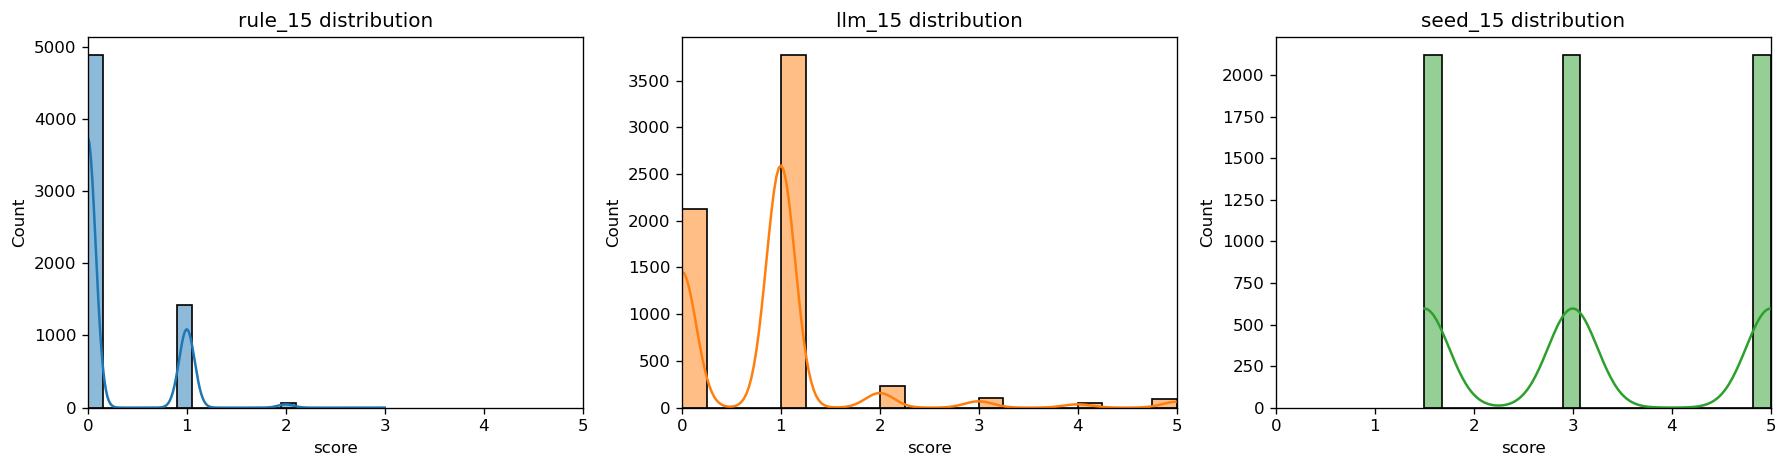

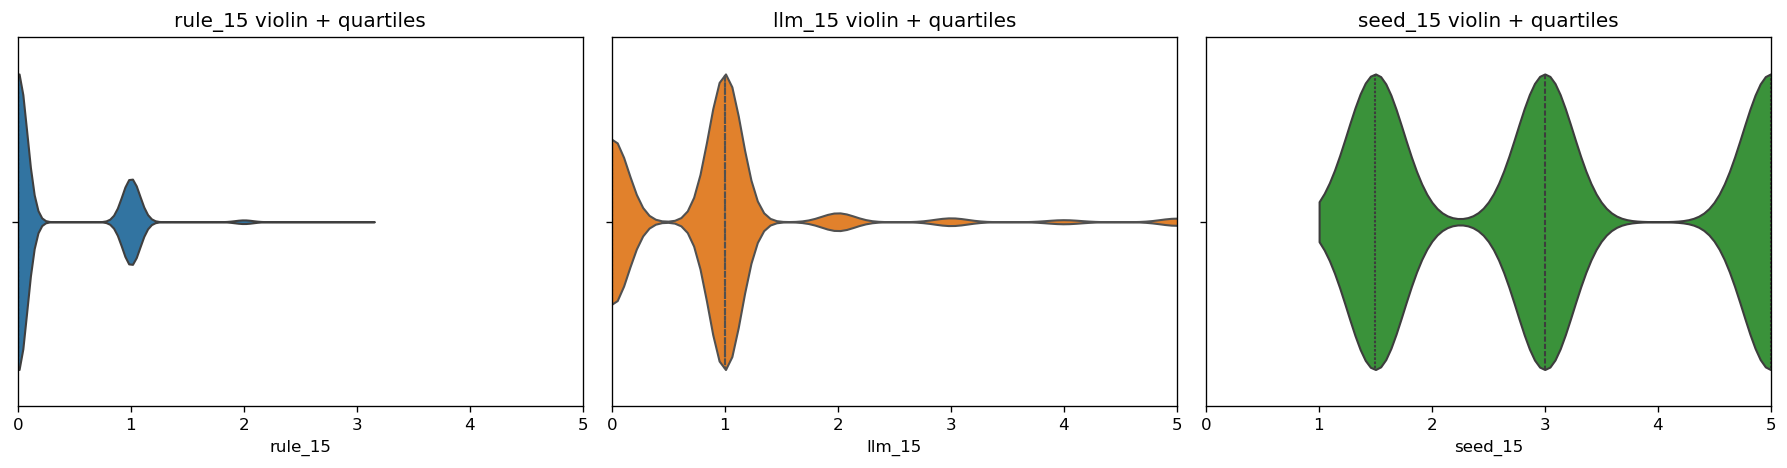

In [ ]:
print("== 분포 체크 ==")
print(
    aug_df[["rule_15","llm_15","seed_15","final_hybrid"]]
    .describe()
    .loc[["mean","std","min","25%","50%","75%","max"]]
    .round(3)
)
# 추가: 각 점수 분포 시각화 (히스토그램+KDE, boxplot)
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

cols = ["rule_15", "llm_15", "seed_15"]
plt.rcParams.update({"figure.dpi": 120})

# 히스토그램 + KDE
fig, axes = plt.subplots(1, len(cols), figsize=(5 * len(cols), 4))
for i, c in enumerate(cols):
    sns.histplot(aug_df[c].dropna(), bins=20, kde=True, ax=axes[i], color="C{}".format(i))
    axes[i].set_title(f"{c} distribution")
    axes[i].set_xlim(0, 5)
    axes[i].set_xlabel("score")
plt.tight_layout()
plt.show()

# 박스플롯 + 바이올린(중앙값/분포 확인)
fig, axes = plt.subplots(1, len(cols), figsize=(5 * len(cols), 4))
for i, c in enumerate(cols):
    sns.violinplot(x=aug_df[c].dropna(), inner="quartile", ax=axes[i], color="C{}".format(i))
    axes[i].set_title(f"{c} violin + quartiles")
    axes[i].set_xlim(0, 5)
plt.tight_layout()
plt.show()

# 저장 (옵션)
import os
os.makedirs("empathy_out/figs", exist_ok=True)
fig.savefig("empathy_out/figs/scores_violin.png", bbox_inches="tight")

## 각 항목들을 1~5딘위로 바꾼다음 최종 라벨 계산해주기

In [ ]:
aug_df["rule_15_clip"] = aug_df["rubric_score"].apply(to_15_from_05)
aug_df["llm_15_clip"] = aug_df["llm_15"].apply(to_15_from_05)
aug_df["seed_15_clip"] = aug_df["seed_score"].clip(1, 5)
# 여기 heuristic하게 바꾸었음 -> 이후 인간 피드백을 통해서 최적의 값 찾을 수 있음.
W_RULE, W_LLM, W_SEED = 0.2, 0.3, 0.5
aug_df["final_hybrid"] = (
    W_RULE*aug_df["rule_15_clip"] + W_LLM*aug_df["llm_15_clip"] + W_SEED*aug_df["seed_15_clip"]
).clip(1, 5)

== 분포 체크 ==
      rule_15_clip  llm_15_clip  seed_15_clip  final_hybrid
mean         1.194        1.653         3.167         2.318
std          0.361        0.670         1.434         0.889
min          1.000        1.000         1.500         1.250
25%          1.000        1.000         1.500         1.250
50%          1.000        1.800         3.000         2.240
75%          1.000        1.800         5.000         3.240
max          3.400        5.000         5.000         4.520


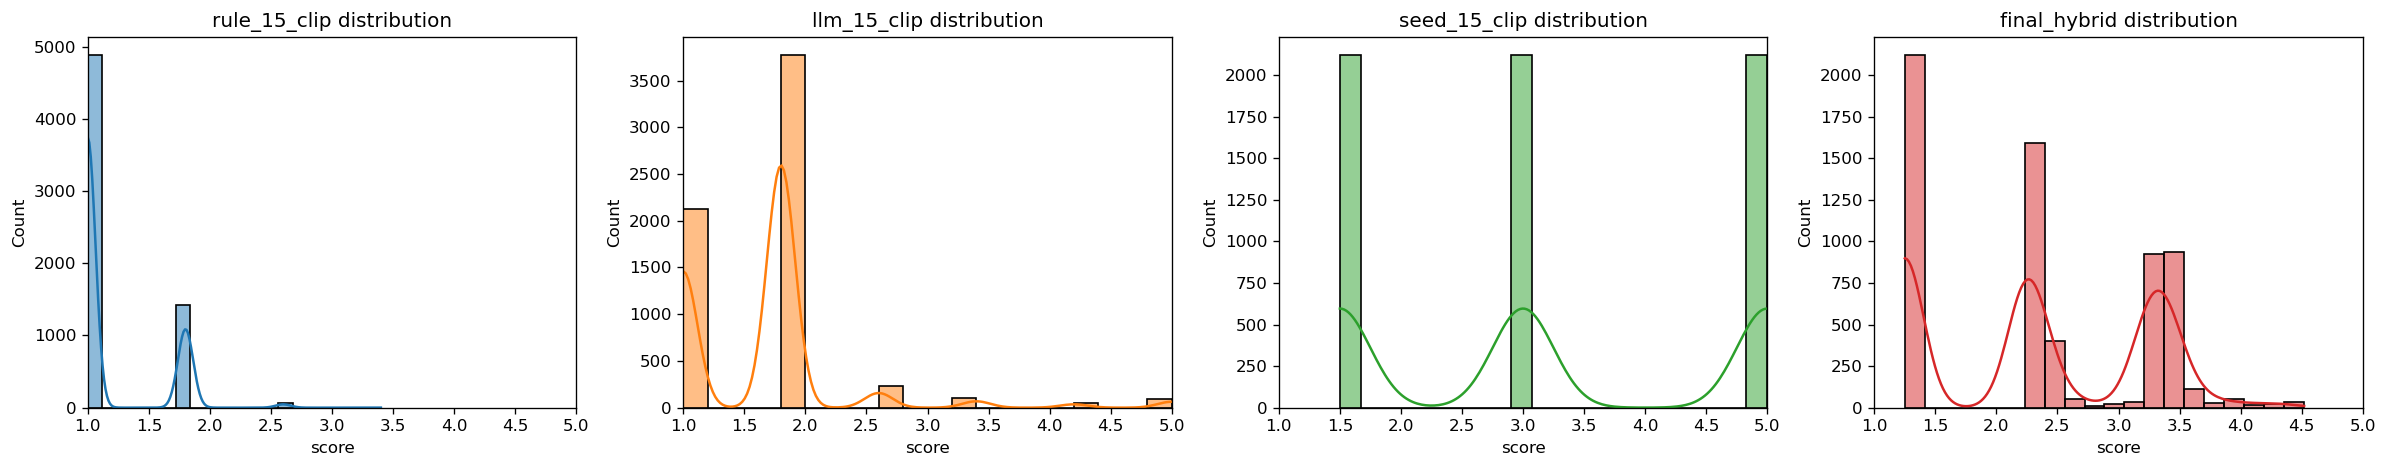

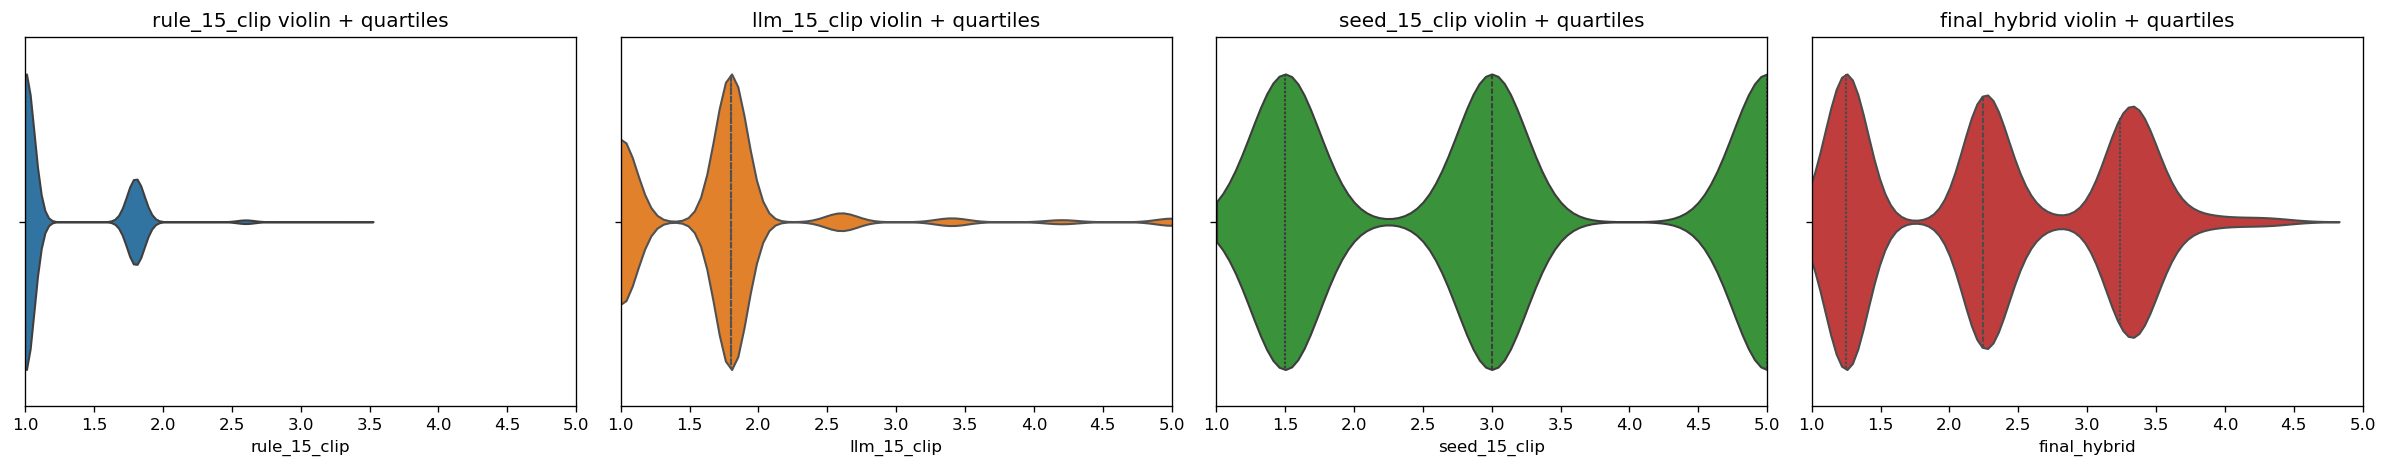

In [27]:
print("== 분포 체크 ==")
print(
    aug_df[["rule_15_clip","llm_15_clip","seed_15_clip","final_hybrid"]]
    .describe()
    .loc[["mean","std","min","25%","50%","75%","max"]]
    .round(3)
)

%matplotlib inline

cols = ["rule_15_clip", "llm_15_clip", "seed_15_clip","final_hybrid"]
plt.rcParams.update({"figure.dpi": 120})

# 히스토그램 + KDE
fig, axes = plt.subplots(1, len(cols), figsize=(5 * len(cols), 4))
for i, c in enumerate(cols):
    sns.histplot(aug_df[c].dropna(), bins=20, kde=True, ax=axes[i], color="C{}".format(i))
    axes[i].set_title(f"{c} distribution")
    axes[i].set_xlim(1, 5)
    axes[i].set_xlabel("score")
plt.tight_layout()
plt.show()

# 박스플롯 + 바이올린(중앙값/분포 확인)
fig, axes = plt.subplots(1, len(cols), figsize=(5 * len(cols), 4))
for i, c in enumerate(cols):
    sns.violinplot(x=aug_df[c].dropna(), inner="quartile", ax=axes[i], color="C{}".format(i))
    axes[i].set_title(f"{c} violin + quartiles")
    axes[i].set_xlim(1, 5)
plt.tight_layout()
plt.show()

# 저장 (옵션)
import os
os.makedirs("empathy_out/figs", exist_ok=True)
fig.savefig("empathy_out/figs/scores_violin.png", bbox_inches="tight")

# 데이터 저장하기

### 데이터 형태
A. CSV / Parquet - 분석, 디버깅 용도

B. Train/Val/Test CSV/ Parquet - 분석, 데이터 검증

C. hf_raw - 텍스트 기반 HF dataset(전처리용)

D. hf_tokenized_roberta-base

In [32]:
# ============================================
# A) 전체 테이블 저장 (CSV/Parquet)
# ============================================
import numpy as np
import os
from sklearn.model_selection import train_test_split

os.makedirs("empathy_out", exist_ok=True)

# float32로 저장(용량↓)
save_cols = [
    "conv_id","context","response","emotion","type",
    "rubric_score","seed_score","llm_15","rule_15","seed_15","final_hybrid"
]
for c in ["rubric_score","seed_score","llm_15","rule_15","seed_15","final_hybrid"]:
    aug_df[c] = aug_df[c].astype(np.float32)

aug_df.to_parquet("empathy_out/aug_full_hybrid.parquet", index=False)
aug_df.to_csv("empathy_out/aug_full_hybrid.csv", index=False, encoding="utf-8")
print("[SAVE] empathy_out/aug_full_hybrid.parquet, .csv")

[SAVE] empathy_out/aug_full_hybrid.parquet, .csv


In [33]:
# ============================================
# B) conv_id 기준 Train/Val/Test 분할 + 저장
#    - 라벨: final_hybrid
# ============================================
RANDOM_SEED = 42

unique_convs = aug_df["conv_id"].unique()
train_ids, rest_ids = train_test_split(unique_convs, test_size=0.2, random_state=RANDOM_SEED, shuffle=True)
val_ids,   test_ids  = train_test_split(rest_ids, test_size=0.5, random_state=RANDOM_SEED, shuffle=True)

def filter_by_ids(df_, ids):
    return df_[df_["conv_id"].isin(ids)].reset_index(drop=True)

train_df = filter_by_ids(aug_df, train_ids)
val_df   = filter_by_ids(aug_df, val_ids)
test_df  = filter_by_ids(aug_df, test_ids)

print("Split sizes | train / val / test:", len(train_df), len(val_df), len(test_df))

# 파일 저장
train_df.to_parquet("empathy_out/empathy_train_hybrid.parquet", index=False)
val_df.to_parquet("empathy_out/empathy_val_hybrid.parquet", index=False)
test_df.to_parquet("empathy_out/empathy_test_hybrid.parquet", index=False)

train_df.to_csv("empathy_out/empathy_train_hybrid.csv", index=False, encoding="utf-8")
val_df.to_csv("empathy_out/empathy_val_hybrid.csv", index=False, encoding="utf-8")
test_df.to_csv("empathy_out/empathy_test_hybrid.csv", index=False, encoding="utf-8")
print("[SAVE] empathy_out/empathy_*_hybrid.parquet/.csv")


Split sizes | train / val / test: 5076 627 669
[SAVE] empathy_out/empathy_*_hybrid.parquet/.csv


In [34]:
# ============================================
# C) (옵션) Hugging Face Dataset로 저장
#    - 라벨 컬럼 명: label = final_hybrid
# ============================================
from datasets import Dataset, DatasetDict

train_df_hf = train_df.copy()
val_df_hf   = val_df.copy()
test_df_hf  = test_df.copy()

for df_ in (train_df_hf, val_df_hf, test_df_hf):
    df_["label"] = df_["final_hybrid"].astype(np.float32)

cols_keep = ["context","response","label","conv_id","emotion","type","final_hybrid",
             "llm_15","rule_15","seed_15"]

train_hf = Dataset.from_pandas(train_df_hf[cols_keep], preserve_index=False)
val_hf   = Dataset.from_pandas(val_df_hf  [cols_keep], preserve_index=False)
test_hf  = Dataset.from_pandas(test_df_hf [cols_keep], preserve_index=False)

ds = DatasetDict({"train": train_hf, "validation": val_hf, "test": test_hf})
os.makedirs("empathy_out/hf_raw", exist_ok=True)
ds.save_to_disk("empathy_out/hf_raw")
print("[SAVE] empathy_out/hf_raw (DatasetDict.save_to_disk)")

Saving the dataset (0/1 shards):   0%|          | 0/5076 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/627 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/669 [00:00<?, ? examples/s]

[SAVE] empathy_out/hf_raw (DatasetDict.save_to_disk)


In [35]:
from datasets import load_from_disk

# ds = load_from_disk("empathy_out/hf_raw")  # 이미 ds가 있다면 생략
all_emos = set(ds["train"]["emotion"]) \
         | set(ds["validation"]["emotion"]) \
         | set(ds["test"]["emotion"])

emo2id = {e: i for i, e in enumerate(sorted(all_emos))}
print("emotion2id:", emo2id)

def add_emotion_id(example):
    example["emotion_id"] = int(emo2id[example["emotion"]])
    return example

ds_with_emo = ds.map(add_emotion_id)

# 필요하면 저장해도 됨 (선택)
ds_with_emo.save_to_disk("empathy_out/hf_raw_with_emo")
print("[SAVE] empathy_out/hf_raw_with_emo")

emotion2id: {'afraid': 0, 'angry': 1, 'annoyed': 2, 'anticipating': 3, 'anxious': 4, 'apprehensive': 5, 'ashamed': 6, 'caring': 7, 'confident': 8, 'content': 9, 'devastated': 10, 'disappointed': 11, 'disgusted': 12, 'embarrassed': 13, 'excited': 14, 'faithful': 15, 'furious': 16, 'grateful': 17, 'guilty': 18, 'hopeful': 19, 'impressed': 20, 'jealous': 21, 'joyful': 22, 'lonely': 23, 'nostalgic': 24, 'prepared': 25, 'proud': 26, 'sad': 27, 'sentimental': 28, 'surprised': 29, 'terrified': 30, 'trusting': 31}


Map:   0%|          | 0/5076 [00:00<?, ? examples/s]

Map:   0%|          | 0/627 [00:00<?, ? examples/s]

Map:   0%|          | 0/669 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5076 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/627 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/669 [00:00<?, ? examples/s]

[SAVE] empathy_out/hf_raw_with_emo


In [36]:
# ============================================
# D) (옵션) 토크나이즈된 HF Dataset도 저장
#    - 예: roberta-base (한글 위주면 KoBERT 등으로 교체)
# ============================================
from transformers import AutoTokenizer
MODEL_NAME = "roberta-base"   # 한국어 위주면 'klue/roberta-base' 또는 'skt/kobert-base-v1' 등으로 교체

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def format_pair(example):
    return {"text_pair_fmt": f"CTX: {example['context']} [SEP] RSP: {example['response']}"}

# ds_fmt = ds.map(format_pair)
ds_fmt = ds_with_emo.map(format_pair)

def tokenize_batch(batch):
    enc = tokenizer(
        batch["text_pair_fmt"],
        padding="max_length",
        truncation=True,
        max_length=256,
    )
    enc["labels"] = [float(x) for x in batch["label"]]  # 회귀 라벨
    enc["emotion_labels"] = batch["emotion_id"]  
    return enc

tokenized = ds_fmt.map(
    tokenize_batch,
    batched=True,
    remove_columns=ds_fmt["train"].column_names
)

os.makedirs("empathy_out/hf_tokenized_"+MODEL_NAME.replace("/","_"), exist_ok=True)
tokenized.save_to_disk("empathy_out/hf_tokenized_"+MODEL_NAME.replace("/","_"))
print(f"[SAVE] empathy_out/hf_tokenized_{MODEL_NAME.replace('/','_')}")

Map:   0%|          | 0/5076 [00:00<?, ? examples/s]

Map:   0%|          | 0/627 [00:00<?, ? examples/s]

Map:   0%|          | 0/669 [00:00<?, ? examples/s]

Map:   0%|          | 0/5076 [00:00<?, ? examples/s]

Map:   0%|          | 0/627 [00:00<?, ? examples/s]

Map:   0%|          | 0/669 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5076 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/627 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/669 [00:00<?, ? examples/s]

[SAVE] empathy_out/hf_tokenized_roberta-base


# tokenizer를 거친 후의 모양
{
   
   "input_ids": [[...256 tokens...], [...], ...],

   "attention_mask": [[...256 values...], [...], ...],

   "labels": [3.8, 1.2, 4.7, ...],        # 회귀 공감 점수

   "emotion_labels": [7, 3, 12, ...]      # 감정 분류 클래스 ID

}